# Integrated Resilience Optimization Architectures


**DISCLAIMER: Optimization modules do not work currently, see RAD-225**

In [3]:
import numpy as np
from fmdtools.sim import propagate
from fmdtools.sim.search import ProblemInterface
import fmdtools.analyze as an
import multiprocessing as mp

In this notebook, we use the drone model defined in `drone_mdl_opt.py` to illustrate the use of the `ProblemInterface` class to set up optimization architectures. Prior to viewing this study, it may be helpful to get some background on the problem and optimization architectures, thus it may be helpful to review the following references:
- Hulse, D., Biswas, A., Hoyle, C., Tumer, I. Y., Kulkarni, C., & Goebel, K. (2021). Exploring Architectures for Integrated Resilience Optimization. Journal of Aerospace Information Systems, 18(10), 665-678.
    - This reference presents a version of this Drone Optimization case study, and also introduces the concept of a resilience optimization architecture. 
    - This drone case study can further be viewed here: https://github.com/DesignEngrLab/resil_opt_examples/tree/main/Drone%20Problem
- Hulse, D., & Hoyle, C. (2022). Understanding Resilience Optimization Architectures: Alignment and Coupling in Multilevel Decomposition Strategies. Journal of Mechanical Design, 144(11), 111704.
    - This reference provides a better review of what is meant by "optimization architectures" as well as different formulations which may be used in this context. While not necessary for comprehending this demonstration, it may be helpful for understanding how it should be used in practice.

In [4]:
from drone_mdl_opt import Drone

mdl = Drone()

This drone has similar structure and behaviors to the drone in `drone_mdl_hierarchical.py` (see below), encompassing the autonomous path planning, control, rotors, electrical system, and control of the drone. However, this model has been parameterized with the following parameters:

- The rotor and battery architecture can be changed
- The flight height can be changed to support different heights, which in turn changes the drone's flight plan
- There is now a `ManageHealth` function which reconfigures the flight depending on detected faults.

In [5]:
from fmdtools.analyze.graph import ModelGraph

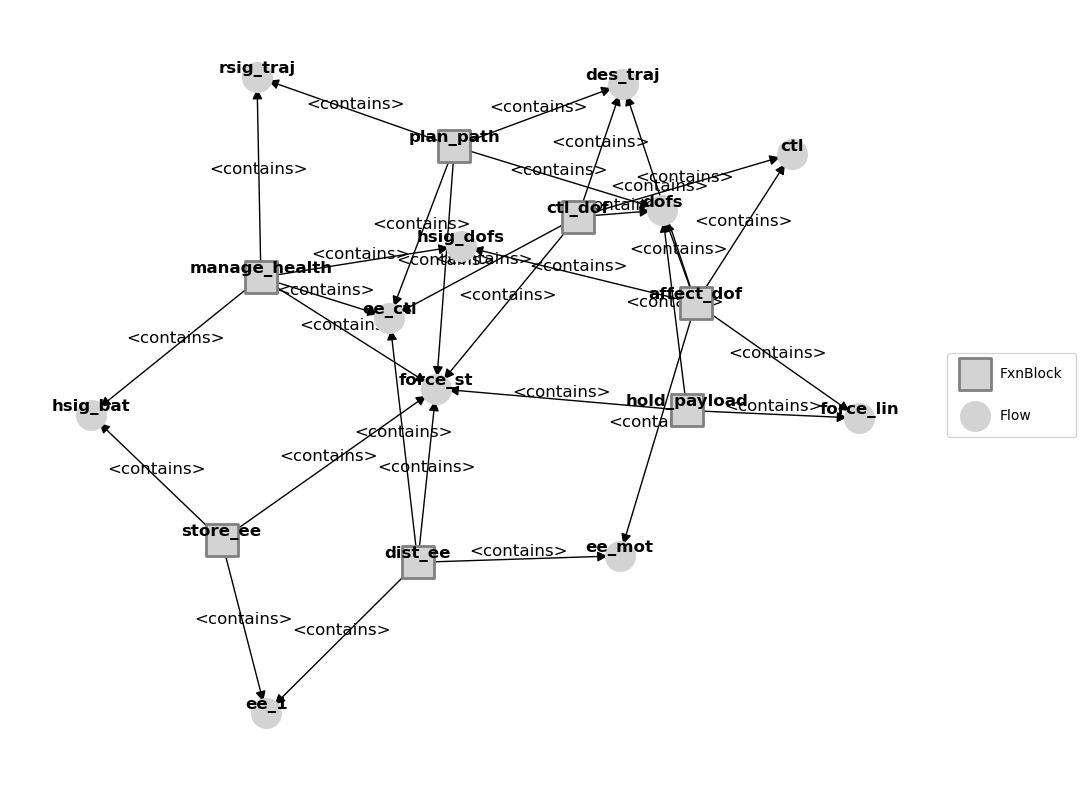

In [6]:
mg = ModelGraph(mdl)
fig, ax = mg.draw()

This is what is called and *integrated resilience optimization* problem, the combined optimization of Design (cost of design architecture), Operations (cost/revenue of a single flight), and Resilience (cost of a set of hazardous scenarios).

Note that it is *integrated* because design model/variables (architecture) affects the operational model/variables (nominal flight), which in turn affects the resilience model (performance over scenarios).

Below we define each of these disciplines. First a problem should be instantiated:

In [7]:
opt_prob = ProblemInterface("drone_problem", mdl)

## Design Model

The cost model for the architectures is fairly simple, and involves reading costs from a dictionary (rather than any sort of dictionary). As a result, we call it from an external function, as shown:

In [8]:
bats = ['monolithic', 'series-split', 'parallel-split', 'split-both']
linarchs = ['quad', 'hex', 'oct']
batcostdict = {'monolithic':0, 'series-split':300, 'parallel-split':300, 'split-both':600}
linecostdict = {'quad':0, 'hex':1000, 'oct':2000}
def x_to_dcost(xdes):
    descost = batcostdict[bats[int(xdes[0])]] + linecostdict[linarchs[int(xdes[1])]]
    return descost

To make this a part of the `ProblemInterface`, we add it as an external simulation using the following syntax: 

In [9]:
opt_prob.add_simulation("design_model", "external", x_to_dcost)

we can further add the associated objectives and variables:

In [10]:
opt_prob.add_objectives("design_model", cd="cd")
opt_prob.add_variables("design_model",('batteryarch',(0,3)),('linearch',(0,3)))

We can then use the `cd` callable to the the design cost from this model in terms of the battery and line architecture variables:

In [11]:
opt_prob.cd([0,0])

0

In [12]:
opt_prob.cd([2,0])

300

In [13]:
opt_prob.cd([2,2])

2300

## Operational Model

The operational model comes from the flight height of the drone and its performance in the nominal scenario. To optimize this, we define the following parameters, which specify that the model is optimized in a single scenario, where using `xd_paramfunc` as a function that translates the design variables into model parameters: 

In [14]:
def xd_paramfunc(xdes):
    return {'bat':bats[int(xdes[0])],'linearch':linarchs[int(xdes[1])]}

In [15]:
opt_prob.add_simulation("operational_model", "single", {}, staged=False,
                        upstream_sims = {"design_model":{'paramfunc':xd_paramfunc}})

We can further define the following objectives and constraints:

In [16]:
opt_prob.add_objectives("operational_model", co="expected cost")
opt_prob.add_constraints("operational_model", g_soc=("store_ee.s.soc", "vars", "end",("greater", 20)),
                                  g_max_height=("dofs.s.z", "vars", "all", ("less", 122)),
                                  g_faults=("repcost", "endclass", "end", ("less", 0.1)))

The flight height controls the flight plan, which is a parameter in the model that results from the function `plan_flight`. As a result, we can't just define it as a normal model parameter, instead we have to send the function `plan_flight` as the vartype, see:

In [17]:
from drone_mdl_opt import plan_flight

In [18]:
opt_prob.add_variables("operational_model", "height", vartype=plan_flight)

We can now use the `co` callable (note that design variables should be sent first e.g. by calling `cd`):

In [19]:
opt_prob.cd([2,2])
opt_prob.co([50])

Faults found during the nominal run {'store_ee': ['s1p2_lowcharge', 'lowcharge', 's1p1_lowcharge']}


20000000.0

In [20]:
opt_prob.co([10])

19947829.861346584

In [21]:
opt_prob.co([20])

16717611.994080093

In [22]:
opt_prob.co([150])

-300052.49013183225

Note that we can view the results of these simulations by looking in `_sims`, provided the history is being tracked. 

In [21]:
fig, ax = an.plot.hist(opt_prob._sims['operational_model']['mdlhists']['nominal'], 
                       "dofs.s.x", "dofs.s.y", "dofs.s.z", 
                       "store_ee.s.soc","ee_mot.s.rate",
                       "ee_1.s.rate", time_slice=6)

In [22]:
from drone_mdl_opt import plot_nomtraj

In [23]:
plot_nomtraj(opt_prob._sims['operational_model']['mdlhists']['nominal'], 
             opt_prob._sims['operational_model']['c_mdls'][0].p, title='Nominal Simulation')

Note also how the cost model changes depending on the design model (Due to weight/capacity):

In [24]:
opt_prob.cd([2,1])
opt_prob.g_soc([50])

In [25]:
opt_prob.cd([0,1])
opt_prob.g_soc([50])

## Resilience Model

We can finally set this problem up with a resilience model portion. Similar to the operational cost model, the inputs of the resilience model are outputs of the operational model, which we account for using the upstream_sims option. Additionally, because the architecture changes, the approach is regenerated at each time with the arguments `app_args` as well as updated phases from the nominal simulation (which we do by sending the `phases` parameter).

Additionally, since the approach is regenerated from the operational cost model, we don't have to provide an initial approach. 

To explain this input, we will be optimizing the expected cost over the single-fault battery faults which occur when the drone is moving (planpath=move phase).

In [26]:
opt_prob.add_simulation("resilience_model", "multi", [], include_nominal=False,\
                        upstream_sims={'operational_model':{'phases':{'plan_path':'move'},'pass_mdl':[]}},\
                        app_args={'faults':('single-component', 'store_ee')},\
                        staged=False)

We further define the objectives for the resilience model:

In [27]:
opt_prob.add_objectives("resilience_model", cr="expected cost")

As well as the variable for the resilience policy, which, (like the operational parameters) is translated into a parameter using the function `spec_respol`:

In [28]:
from drone_mdl_opt import ResPolicy

In [29]:
respols = ['continue', 'to_home', 'to_nearest', 'emland']

def spec_respol(bat, line):
    return {'respolicy': ResPolicy(bat=respols[int(bat)], line=respols[int(line)])}
opt_prob.add_variables("resilience_model", "bat","line", vartype=spec_respol)

We can now use the callable `cr`:

In [30]:
opt_prob.cd([2,1])
opt_prob.co([100])
opt_prob.cr([1,0])

In [31]:
opt_prob.cr([2,0])

In [32]:
opt_prob.cr([0,0])

## Combined Simulation/Optimization
We thus have a combined optimization architecture, where each model callable can be called externally while keeping dependent relationships with the upstream models. We can view these architectures using:

In [33]:
fig = opt_prob.show_architecture()

We can also define a combined objective summing each of the costs from each model:

In [34]:
opt_prob.add_combined_objective("total_cost", 'cd', 'co', 'cr')

In [35]:
opt_prob.total_cost([1,1],[100],[1,1])

In [36]:
opt_prob.total_cost([1,1],[100],[1,1])

To get an idea of the times of the different simulations, we can also use the method `time_sims` (provided a given variable).

In [37]:
_ = opt_prob.time_sims([1,1,100,1,1])

We can further speed this up by updating the simulation options to track specific parts of the model history (instead of all) as well as provide a multiprocessing pool.

In [38]:
opt_prob.update_sim_options("resilience_model", log_iter_hist=True, pool=mp.Pool(4), 
                            track={"fxns":{"store_ee":"faults"}, "flows":{"dofs":"s"}})

In [39]:
_ = opt_prob.time_sims([1,1,100,1,1])

Note that cost savings from parallelism often come after a single simulation (since initialization of the pool takes time), but are still not major in this case. This is because the parameters in the approach both require re-instantiation of the model (which is a significant amount of the computational cost). 

In [40]:
_ = opt_prob.time_sims([1,1,100,1,1])

Below we show a very simple optimization of these variables using brute force search. Much more sophisticated architectures/methods can be used on this problem, this code is mainly to demonstrate how these disciplines can be used together as a single objective/problem.

In [41]:
import itertools
def brute_search(Xranges = [[0,4,1],[0,3,1],[10, 130, 10],[0,4,1],[0,4,1]]):
    Xvals = [ e for e in itertools.product(*(range(x[0],x[1],x[2]) for x in Xranges))]
    results = dict(); opt_hist = []
    for X in Xvals:
        tot_cost = opt_prob.total_cost(X[:2], [X[2]], X[3:])
        is_feasible = all([i<=0.0 for k,i in opt_prob.current_iter['consts'].items() if 'set' not in k])
        if not opt_hist:                                     opt_hist= [[tot_cost, X]]
        elif tot_cost < opt_hist[-1][0] and is_feasible:     opt_hist.append([tot_cost, X])
    return opt_hist

In [42]:
opt_hist = brute_search()

In [44]:
opt_prob.total_cost([2,2,40,1,0])

In [45]:
from matplotlib import pyplot as plt

The full history of objective values can be viewed in `iter_hist`:

In [46]:
plt.plot(opt_prob.iter_hist['cd'])

In [47]:
plt.plot(opt_prob.iter_hist['co'])

In [48]:
plt.plot(opt_prob.iter_hist['cr'])

In [49]:
opt_hist[-1]

This illustrates the use of a monolithic optimization architecture for exploring the variables in these sims. We could create more, per the references, or use specialized methods to speed up the search:
- e.g., using one of the architectures (bilevel, multi-stage, etc) defined previously
- searching the variables with a specialized optimization method (e.g., tree search)
- Setting the policy as a disturbance, rather than a parameter. This would enable staged execution of the resilience scenarios, greatly decreasing computational time.